<font color='darkblue'>
# **Network Metrics and Growth as a Change in BTC:USD**
##### The main idea here is to briefly explore a potential network metric that can be used as an input for price growth. As such, I'm going to focus on `PriceUSD`. Other metrics can be used interchangeably for the entirety of this review, say, for example, depending on one's desires, active addresses within some period of time, hash rate, businesses accepting Bitcoin, or even number of laws passed with the word 'bitcoin' could be an interpretation of growth and thus linked to price. I downloaded `btc.csv` and `metrics_info.csv` from Coin Metric's free tools page (https://tools.coinmetrics.io/). Some questions one might want to ask are,
##### _What network metrics could be used to understand or predict price increases?_
##### _What is a good way to lessen noise in (these) metrics?_
##### _Should data be transformed in any way?_
##### First, we'll load the data and clean it up a bit as there's many blanks, unwanted NAs, zero variance values, etc. Given that our growth is based on BTC/USD value, we only want to focus on when BTC had an agreed upon USD value.

In [22]:
#install.packages('ggplot2')
library(ggplot2)

btc <- read.table("btc.csv", sep=",", header=TRUE)
abb <- read.table("metrics_info.csv", sep=",", header=TRUE, row.names=1)

# Remove non-numeric, no variance data, and 'clean' via NA replacement with zero
btc <- btc[sapply(btc, is.numeric)]
btc <- btc[ - as.numeric(which(apply(btc, 2, var) == 0))]
btc[is.na(btc)] <- 0

# Finally, only trade-era BTC data is used and removed from the data set
btc <- subset(btc, PriceUSD > 0)

# To reduce some of the daily noise, we're aggregating on a 14 day time frame around the mean for each epoch
n <- 14
btc <- aggregate(btc, list(rep(1:(nrow(btc) %/% n + 1), each = n, len = nrow(btc))), mean)[-1]

# We don't want to compare to `PriceUSD` at any point, so we'll remove it from the data and use it independently
btcprice <- btc$PriceUSD
btc <- subset(btc, select = - PriceUSD)

<font color='darkblue'>

##### Now that we've got a cleaned data set of `btc` 14-day aggregated by means to work off, we'll compare `btcprice` against each metric using `ccf()`, a base-R Cross-Correlation Function which we'll use in two ways: assess the direct as well as a lag-based impact on `PriceUSD`.

In [23]:
# Create `name` to use as a length variable as well as `results` to store data as it's generated
name <- colnames(btc)
results <- c()

# This loop will compare `PriceUSD` against all 'suriving' metrics post clean-up
for (i in seq(1,length(name))){

    # Try this with and without log price
    ccfobj <- ccf(btcprice, btc[i], type='correlation', plot = FALSE)
    corcoef <- ccfobj$acf
    laglist <- ccfobj$lag

    # By using squares, we're able to determine which direction the highest/lowest correlation `ce` is going
    ce <- if ( max(corcoef)^2 > min(corcoef)^2 ) {
        max(corcoef)
        } else { 
        min(corcoef)
        }

    # There's probably a much more elegant way to `match` coefficient values and lag value, but in the interest of time...
    matchlist <- cbind(laglist, corcoef)

    agg <- c(subset(matchlist, laglist == 0)[2],
            subset(matchlist, corcoef == ce)[2],
            round(subset(matchlist, corcoef == ce)[1])
            )

    # Results stores the aggregated values of unshifted correlation coefficient, best `ce`, lag as shift for each comparison
    results <- rbind(results, agg)
}

rownames(results) <- name
# Add category from `metrics_info.csv`
results <- cbind(results, abb[name,][2])
colnames(results) <- c('Coefficient', 'Best', 'Shift','Category')

<font color='darkblue'>
##### Now we can begin interrogating our `results` object by viewing the data.

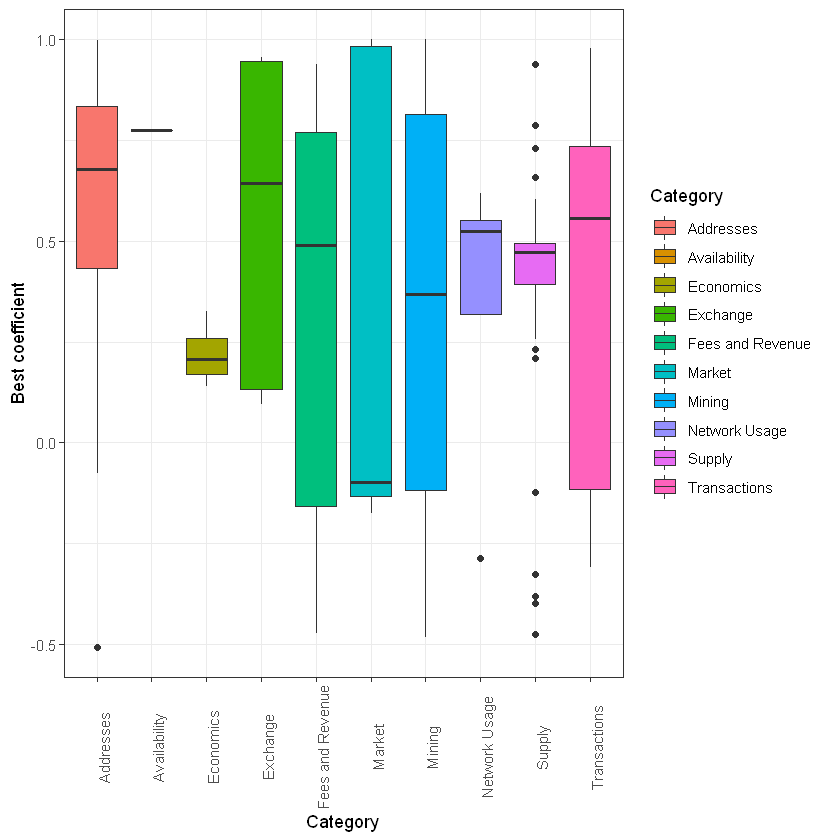

In [24]:
ggplot(results, aes(x = Category, y = Best, fill = Category)) +
    geom_boxplot() +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90)) + ylab("Best coefficient")

<font color='darkblue'>
##### At this point we're beginning to be able to answer our first question, as we can see some categories have higher median 'best Coefficients' than others. For example, `Addresses`, `Exchange`, and `Network Usage` tend to have relatively high coefficients, and a reasonable distribution around their median values, suggesting a certain level of confidence that these metrics may be indicative of being able to understand market movements at least on a macro, 14-day scale. Some metrics such as `Fees and Revenue`, `Market`, and `Mining` seem to have a large spread in correlation coefficients even after taking the best lag position from `ccf()`, but we'll investigate this further below.

In [25]:
# Let's take the top five best fitting coeffcients from each category to whittle down a beter perspective
num = 5
toptable <- results[order(results$Best, decreasing = TRUE), ]
toptable <- Reduce(rbind,
            by(toptable,
            toptable["Category"],
            head,
            n = num))

# Arrange the table to make a little more human-sense
toptable <- cbind(toptable$Category, abb[rownames(toptable),][3], abb[rownames(toptable),][1], toptable$Best)
colnames(toptable) <- c('Category', 'Subcategory', 'Fullname', 'Coefficient')
toptable

,Category,Subcategory,Fullname,Coefficient
AdrBalUSD10MCnt,Addresses,Balance,"Addresses, with balance, greater than $10M, count",0.99689434
AdrBalUSD1MCnt,Addresses,Balance,"Addresses, with balance, greater than $1M, count",0.98978697
AdrBalUSD10KCnt,Addresses,Balance,"Addresses, with balance, greater than $10K, count",0.97322934
AdrBalUSD100KCnt,Addresses,Balance,"Addresses, with balance, greater than $100K, count",0.96833373
AdrBalUSD1KCnt,Addresses,Balance,"Addresses, with balance, greater than $1K, count",0.93318155
AssetEODCompletionTime,Availability,NA,Last fully calculated EOD metrics time,0.77482918
NVTAdj90,Economics,Valuation,"NVT, adjusted, 90d MA",0.32670387
NVTAdj,Economics,Valuation,"NVT, adjusted",0.23628702
NVTAdjFF90,Economics,Valuation,"NVT, adjusted, free float, 90d MA",0.17828129
NVTAdjFF,Economics,Valuation,"NVT, adjusted, free float",0.14069147


<font color='darkblue'>
##### Inspecting this, there are some obvious answers and some not-so-obvious answers. For example, of course we'd expect many values to track almost perfectly with `PriceUSD` such as `Addresses:Balance` and `Market:Market Capitalization`. Anything to do with USD here is going to be unhelpfully ideal in determining some kind of potentially predictive model, because if price goes up, all of these go up without question as well.
##### As such, let's filter out all `Fullname` values that have "USD" or a dollar sign in them.

In [26]:
# Filter
topnew <- toptable[!grepl("USD|\\$", toptable$Fullname),]

# Add lag for interpretation
topnew$Lag = results$Shift[match(rownames(topnew),rownames(results))]

# Sort by Coefficient
topnew[order(-topnew$Coefficient),]

,Category,Subcategory,Fullname,Coefficient,Lag
DiffMean,Mining,Difficulty,"Difficulty, mean",0.81434484,0
DiffLast,Mining,Difficulty,"Difficulty, last",0.81414881,0
HashRate30d,Mining,Hash Rate,"Hash rate, mean, 30d",0.81331375,0
AssetEODCompletionTime,Availability,NA,Last fully calculated EOD metrics time,0.77482918,-5
SER,Supply,Current,Supply equality ratio,0.65864718,8
FlowTfrFromExCnt,Exchange,Withdrawals,"Flow, transfers, from exchanges, count",0.64207748,0
TxTfrCnt,Transactions,Transfers,"Transactions, transfers, count",0.62562262,4
BlkSizeMeanByte,Network Usage,Blocks,"Block, size, mean, bytes",0.61827694,1
TxCnt,Transactions,Transactions,"Transactions, count",0.55611656,15
BlkWghtMean,Network Usage,Blocks,"Block, weight, mean",0.52753367,5


##### 

<font color='darkblue'>
## *What network metrics could be used?*
##### Interpreting the table above, now sorted by the best Coefficient, we arrive at some relatively well accepted perspectives; `Mining:Difficulty` and `Mining:Hash Rate` are very aligned with price growth (`lag=0`).  `TxCnt` as mentioned in the PDF is high up enough, however, has a relatively high, positive lag, which indicates some level of forecasting abiltiy (ie Transaction Counts are rising, we should see a spike in price following this). Other metrics we should focus on are high correlation coefficient high positive lag such as `SER` and those from `Network Usage:Blocks`.
    
## *What is a good way to lessen noise*
##### One way to do this was already implemented, taking a two-week moving average (`n = 14`) across the entire data set. Maybe this should be 7 days, or even a whole month. Another way could be investigating `log(btcprice)`; we'll run all the code above again and see how the `topnew` table changes.

In [27]:
name <- colnames(btc)
results <- c()
for (i in seq(1,length(name))){
    ccfobj <- ccf(log(btcprice), btc[i], type='correlation', plot = FALSE)
    corcoef <- ccfobj$acf
    laglist <- ccfobj$lag
    ce <- if ( max(corcoef)^2 > min(corcoef)^2 ) {max(corcoef)} else {min(corcoef)}
    matchlist <- cbind(laglist, corcoef)
    agg <- c(subset(matchlist, laglist == 0)[2],
            subset(matchlist, corcoef == ce)[2],
            round(subset(matchlist, corcoef == ce)[1]))
    results <- rbind(results, agg)
}
rownames(results) <- name
results <- cbind(results, abb[name,][2])
colnames(results) <- c('Coefficient', 'Best', 'Shift','Category')
num = 5
toptable <- results[order(results$Best, decreasing = TRUE), ]
toptable <- Reduce(rbind,
            by(toptable,
            toptable["Category"],
            head,
            n = num))
toptable <- cbind(toptable$Category, abb[rownames(toptable),][3], abb[rownames(toptable),][1], toptable$Best)
colnames(toptable) <- c('Category', 'Subcategory', 'Fullname', 'Coefficient')
topnew2 <- toptable[!grepl("USD|\\$", toptable$Fullname),]
topnew2$Lag = results$Shift[match(rownames(topnew2),rownames(results))]
topnew2[order(-topnew2$Coefficient),]

,Category,Subcategory,Fullname,Coefficient,Lag
SplyExpFut10yr,Supply,Future Expected,"Supply, future expected, next 10yr",0.9713654,0
AdrBal1in10MCnt,Addresses,Balance,"Addresses, with balance, greater than 1in10M, count",0.9411497,0
AdrBalNtv10Cnt,Addresses,Balance,"Addresses, with balance, greater than 10 native units, count",0.9378887,0
AdrBalNtv1KCnt,Addresses,Balance,"Addresses, with balance, greater than 1K native units, count",0.9351429,0
AdrBalNtv1Cnt,Addresses,Balance,"Addresses, with balance, greater than 1 native units, count",0.9288957,0
AdrBal1in100MCnt,Addresses,Balance,"Addresses, with balance, greater than 1in100M, count",0.8976576,0
BlkSizeMeanByte,Network Usage,Blocks,"Block, size, mean, bytes",0.8823667,0
TxTfrCnt,Transactions,Transfers,"Transactions, transfers, count",0.8770293,0
BlkWghtMean,Network Usage,Blocks,"Block, weight, mean",0.8695878,0
BlkWghtTot,Network Usage,Blocks,"Block, weight, total",0.8671576,0


<font color='darkblue'>
##### Lots of new things are cropping up, but it seems lots of these metrics are either at `lag=0` or highly negative, meaning they're *reacting* to Bitcoin's price instead of acting as a predictor. Thus, as it stands right now, we won't be using `log(btcprice)` in calculations. Probably best only for graphical presentation use only. I'm sure lots of other approaches like using z-scores could prove beneficial, but almost an infinite amount of time could be put into validating/exploring this.
## *What about the rate of increase?*
##### There's a few ways to do this, but maybe with simple forecasting and looking at the current year could give us a hint as to whether it is growing rapidly or slowly or perhaps even shrinking.

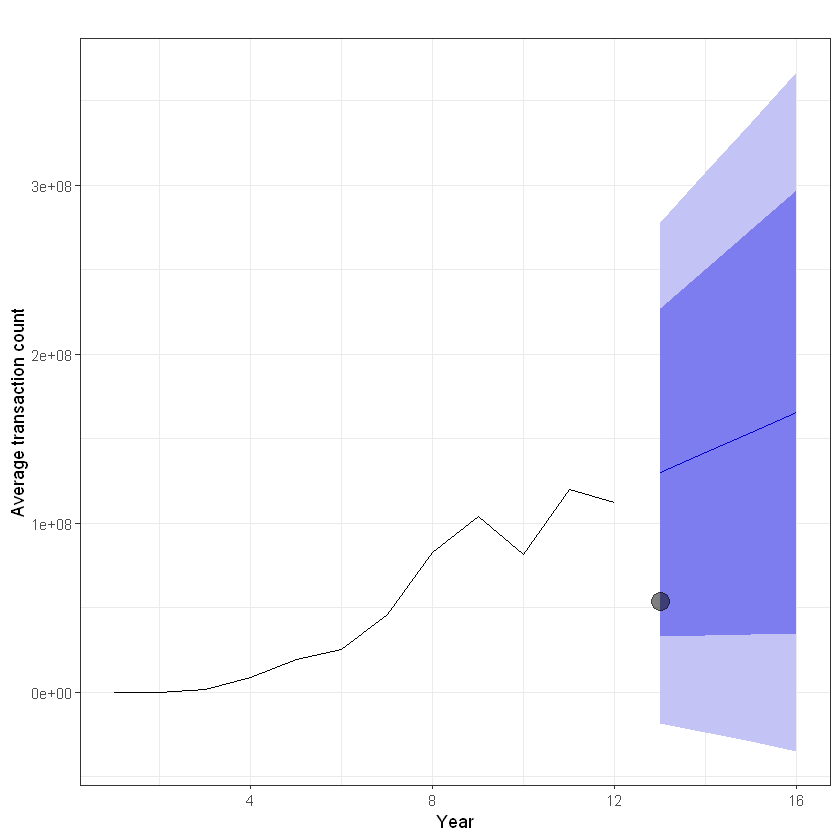

In [28]:
library(forecast)

# Read `btc.csv`, create a matrix of TxCnt by year (assume 365 days) with NA
btctx <- read.table("btc.csv", sep=",", header=TRUE)$TxCnt
ncol <- round(length(btctx)/365)
add <- (365 * ncol) - length(btctx)
btcmat <- matrix(append(btctx,rep(NA,add)),365,ncol)

yearlytx <- as.matrix(colSums(btcmat, na.rm = TRUE))

# We're dropping the current year, as we're only half way through it, and forecasting 3 years out
future <- forecast(yearlytx[1:12],h=4)
autoplot(future) +
    geom_smooth() +
    geom_point(aes(x=ncol, y=yearlytx[13]),
        size=5,
        shape=19,
        alpha=1/2) +
        theme_bw() + xlab("Year") + ylab("Average transaction count") + ggtitle("")

<font color='darkblue'>
##### Looks like it's shrinking! While the forecast above shows us that the average transaction count for this year (black circle) does indeed fall within the 80% confidence interval, it is well below the mean predicted. Writing this on July 15, we're 196 days into the year.

In [29]:
# (Current day ratio) * Forecast model mean for 2021
predtoday <- 195/365*future$mean[1]

round(predtoday/yearlytx[13],2)

[1] 1.29

<font color='darkblue'>
##### The value above tells us we'd need the transaction count mean to be almost 30% higher today to have kept up with the forecast. Transactions are down. Price is down. Yes, it looks like we're in a bit of a bear market.
## *Should the data be transformed?*
##### In general, sticking with `log()` is usually the best way to compare these kinds of large numbers when averages are generally much larger than what we see in a data set. As we saw above though, we lost some of the 'lag power' from `ccf()` when we chose `log(btcprice)` over viewing it untransformed. We could've tried other approaches to normalizing some of these high and low numbers, for example, taking the median (rather than the mean) over longer (or shorter) periods of time. Large positive and negative numbers can be compared similarly how we handled the correlation coefficients, by taking the square of the value.
# *Predicting price increases using `btc.csv`*

In [30]:
# Let's sort by highest lag, pick and choose some metrics with relatively high coefficients
subset(topnew[order(-topnew$Lag),], Coefficient > 0.5 & Lag > 1)

,Category,Subcategory,Fullname,Coefficient,Lag
TxCnt,Transactions,Transactions,"Transactions, count",0.5561166,15
SER,Supply,Current,Supply equality ratio,0.6586472,8
BlkWghtTot,Network Usage,Blocks,"Block, weight, total",0.5203383,7
BlkWghtMean,Network Usage,Blocks,"Block, weight, mean",0.5275337,5
TxTfrCnt,Transactions,Transfers,"Transactions, transfers, count",0.6256226,4


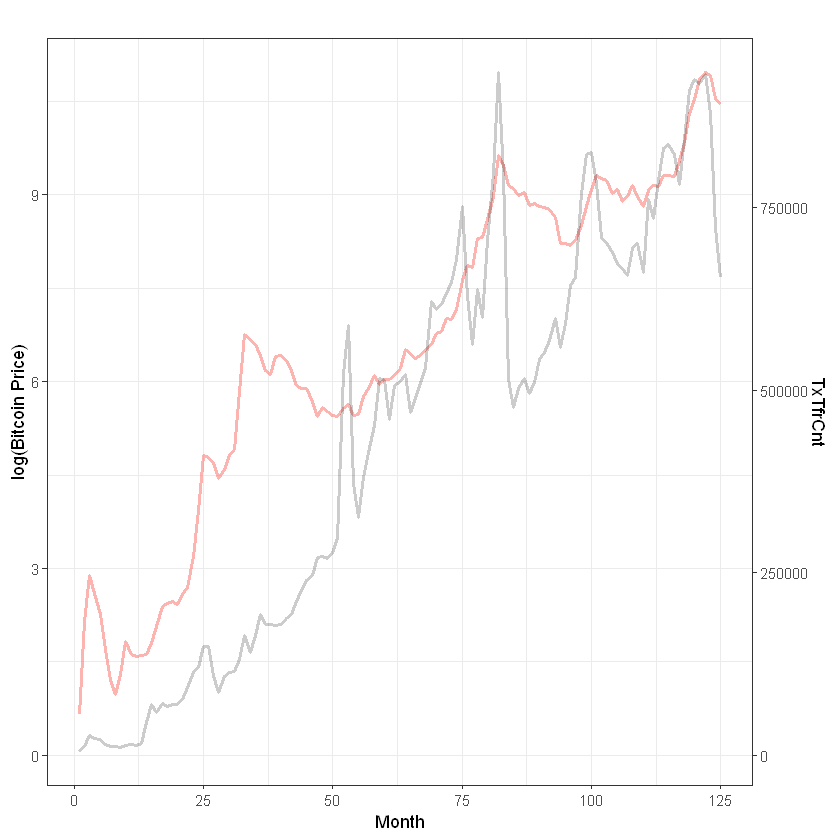

In [31]:
# While TxCnt was the example metric and has been empirically validated as potentially
# the best to use, we'll go with TxTfrCnt instead

# Reload everything, but aggregate to a 30 day time frame to lessen the aggressiveness of the ups and downs

btc <- read.table("btc.csv", sep=",", header=TRUE)

btc <- btc[sapply(btc, is.numeric)]
btc <- btc[ - as.numeric(which(apply(btc, 2, var) == 0))]
btc[is.na(btc)] <- 0

# Going to make this greater than $1 because we're applying ln
btc <- subset(btc, PriceUSD > 1)

n <- 30
btc <- aggregate(btc, list(rep(1:(nrow(btc) %/% n + 1), each = n, len = nrow(btc))), mean)[-1]

btcprice <- btc$PriceUSD
txtfrcnt <- btc$TxTfrCnt

scaleFactor <- max(log(btcprice)) / max(txtfrcnt)

ggplot() +
    geom_line(aes(x = seq(1:length(btcprice)), y = (log(btcprice)), color = "red", alpha = 1/5), size = 1) +
    geom_line(aes(x = seq(1:length(btcprice)), y = (txtfrcnt * scaleFactor)), color = "black", alpha = 1/5, size = 1) +
        scale_y_continuous(name="log(Bitcoin Price)", sec.axis=sec_axis(~./scaleFactor, name="TxTfrCnt")) +
    theme_bw() + xlab("Month") + ylab("log(Bitcoin Price)") + ggtitle("") + theme(legend.position = "none")

<font color='darkblue'>
##### For the most part `TxTfrCnt` (black) seems to be pretty effective in at least identifying peaks (month 100 and before). It also seems to be able to indicate potential enter/exit points post month 100. Note the two major peaks post month 100, which if one were to have exited their position after the `TxTfrCnt` were to start to plateau/decrease, it would generally have been  favorable. The graphic above is really signaling a moment on when a participant might want to enter/exit: we might want to enter when `Transactions, transfers, count` begins to rise rapidly, and consider setting stop losses when they begin to drop dramatically. This could be coded granularly by determining when a positive increase ends significantly.
## *Closing thoughts*
##### In this brief review I only looked at Bitcoin data, and how we might be able to determine some price action. In reality, lots of other factors at this point in Bitcoin's evolution are at play such as stablecoin flows/generation (USDT, USDC), the state of traditional markets (DJIA, SP500, DXY), and even space-racing Twitter entities' casual comments on the asset class. As such, some other metrics could be employed borrowing from other chains' data, assessing futures, or even using sentiment analysis on a select group of ".eth" influencers' handles.
##### I think a lot of these questions could really be infinitely explored here, whether it's taking the log of Bitcoin price, only looking at bull (or bear) run epochs, or associating it with exterior events such as full/new moon cycles. Whether it's incorporating this outside data, cleaning up graphics, or getting into some serious granularity with the data set, hopefully this bird's eye view is sufficient to show how I work with data and begin interrogating big questions such as, "When do I buy, when do I sell?"